This program analyses the breast cancer tumor dataset to find the gene products which are statistically different between stage 1 and stage 2, stage 1 and stage 3 and stage 2 and stage 3 cancer tumors

At the end it applies machine learning to build a model which can be used to predict with an R^2 of .9 to determine the type of the tumor based on the clustered expression levels of the gene products from step 1

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
def santizeTumorGrade(rawTumorGrade):
    noWords = rawTumorGrade.replace('tumour grade: ','')
    if noWords == '.':
        return 0
    else:
        return int(noWords)

In [3]:
def findAllTumorIdsWithGrade(grade, tumorIdToGrade):
    ret = [];
    for k,v in tumorIdToGrade.items():
        if v == grade:
            ret.append(k)
            
    return ret

In [4]:
def constructPdfData(data, bins, cumulate):
    ret = [];
    numBins = len(bins)
    binsRange = range(0,numBins)
    count = len(data) #total number of tumors with this gene
    #initalize the returned data with 0 counts in all bins
    for i in binsRange:
        ret.append(0)
    
    #go through the expressionData and bin it
    for v in data:
        for i in binsRange:
            if i == 0:
                if v < bins[i+1]: #anything lower then the second bin value is in the first bin
                    ret[i] += 1
            elif i == numBins - 1: #anything equal to or higher then the last bin value is in the last bin
                if v >= bins[i]: 
                    ret[i] += 1
            elif v >= bins[i] and v < bins[i+1]:
                ret[i] += 1
    
    #now normalize it
    for i in binsRange:
        ret[i] = ret[i]/count
        
    #then cumulate it if we want to
    if cumulate:
        for i in range(1,numBins):
            ret[i] = ret[i] + ret[i-1]
        
    return ret  

In [5]:
def writeGeneListToFile(fname, geneList):
    with open(fname, 'w') as f:
        for item in geneList:
            f.write("%s\n" % item)

In [6]:
#this is the expression level rows are the genes, columns are the tumors
rawExpressionData = pd.read_csv('data/raw_expression_data.csv', index_col=0)

In [7]:
#this is the identification information for each tumor in each column 
#(contains ProbeId which allows us to identify the gene name)
rawTumorIdent = pd.read_csv('data/raw_ident.csv', encoding = "ISO-8859-1")

In [8]:
#Build dictionary which allows us to look up Gene by ProbeId
searchKeyProbId = pd.read_csv('data/SearchKey_ProbeId.csv')
numRows = searchKeyProbId['Search_key'].size
probeIdToGene = {}
for i in range(0,numRows):
    probeIdToGene[searchKeyProbId['ProbeId'][i]] = searchKeyProbId['Search_key'][i]

In [9]:
#Build a dictionary of tumorId to tumor grade
tumorIdToGrade = {}
tumorGradeRow = rawTumorIdent.values[13] #Row at index 13 contains the tumor grade
tumorIdentRow = rawTumorIdent.values[35] #Row at index 25 contains the tumor identity
numCols = tumorIdentRow.size

for i in range(1,numCols):
    tumorIdToGrade[tumorIdentRow[i]] = santizeTumorGrade(tumorGradeRow[i])

In [10]:
#Build a dictionary of tumor grade [0-4) where the values are the filtered rawExpressionData
#where the grade of the tumor matches the key
tumorsByGrade = {}
for i in range(0,4):
    tumorsByGrade[i] = rawExpressionData[findAllTumorIdsWithGrade(i, tumorIdToGrade)]

([<matplotlib.axis.XTick at 0x120661f60>,
 <a list of 4 Text xticklabel objects>)

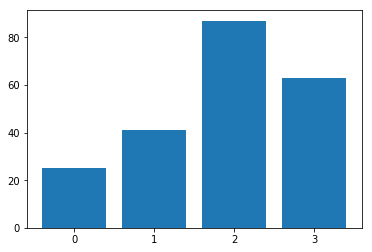

In [11]:
#How many tumors do we have of each type
counts = {k:len(v.columns) for (k,v) in tumorsByGrade.items()}
plt.bar(counts.keys(), counts.values())
plt.xticks([0,1,2,3])

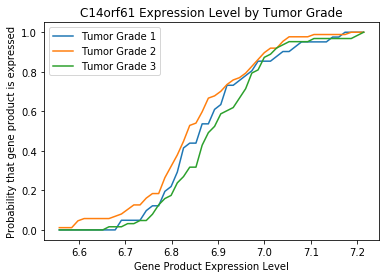

In [12]:
#distrubtion of expression level for a gene segemented by tumor type
geneIdx = 956 #the gene we want to plot by its index
geneIdent = probeIdToGene[rawExpressionData.iloc[geneIdx].name] #its actual name

minVal = tumorsByGrade[1].iloc[geneIdx].min()
maxVal = tumorsByGrade[1].iloc[geneIdx].max()

for i in range(2,4):
    minVal = min(tumorsByGrade[i].iloc[geneIdx].min(), minVal)
    maxVal = max(tumorsByGrade[i].iloc[geneIdx].max(), maxVal)
    
bins = np.linspace(minVal, maxVal, 50)

for i in range(1,4):
    plt.plot(bins, constructPdfData(tumorsByGrade[i].iloc[geneIdx], bins, True), label='Tumor Grade ' + str(i))

plt.title(str(geneIdent) + ' Expression Level by Tumor Grade')
plt.ylabel('Probability that gene product is expressed')
plt.xlabel('Gene Product Expression Level')
plt.legend()

In [13]:
'''
Produces a plot of all gene products for tumors of type 1
tumorGrade = 1
numGenes = len(tumorsByGrade[tumorGrade])
for geneIdx in range(0,numGenes):
    minVal = tumorsByGrade[tumorGrade].iloc[geneIdx].min()
    maxVal = tumorsByGrade[tumorGrade].iloc[geneIdx].max()
    
    bins = np.linspace(minVal, maxVal, 50)
    dat = constructPdfData(tumorsByGrade[tumorGrade].iloc[geneIdx], bins, True)
    plt.plot(bins, dat)

plt.title('Tumor Grade ' + str(tumorGrade) + ' Gene Product Expression')
'''

"\nProduces a plot of all gene products for tumors of type 1\ntumorGrade = 1\nnumGenes = len(tumorsByGrade[tumorGrade])\nfor geneIdx in range(0,numGenes):\n    minVal = tumorsByGrade[tumorGrade].iloc[geneIdx].min()\n    maxVal = tumorsByGrade[tumorGrade].iloc[geneIdx].max()\n    \n    bins = np.linspace(minVal, maxVal, 50)\n    dat = constructPdfData(tumorsByGrade[tumorGrade].iloc[geneIdx], bins, True)\n    plt.plot(bins, dat)\n\nplt.title('Tumor Grade ' + str(tumorGrade) + ' Gene Product Expression')\n"

In [14]:
#test for differences in gene expression by gene by tumor type
alpha = 0.01
numGenes = len(tumorsByGrade[0])

uniqueTypePairs = [[1,2],[2,3],[1,3]]
genesWhichAreDifferentBetweenTypes = {}

for typePair in uniqueTypePairs:
    case = str(typePair[0]) + '<->' + str(typePair[1])
    genesWhichAreDifferentBetweenTypes[case] = []
        
for geneIdx in range(0,numGenes):
    for typePair in uniqueTypePairs:
        case = str(typePair[0]) + '<->' + str(typePair[1])                
        pvalue = stats.ttest_ind(tumorsByGrade[typePair[0]].iloc[geneIdx], tumorsByGrade[typePair[1]].iloc[geneIdx], equal_var = False).pvalue
        if pvalue < alpha:
            geneIdent = probeIdToGene[rawExpressionData.iloc[geneIdx].name] #its actual name
            genesWhichAreDifferentBetweenTypes[case].append(geneIdent)

for k,v in genesWhichAreDifferentBetweenTypes.items():
    print('Between tumor types ', k, ' there are ', len(v), ' genes products which are expressed differently')

Between tumor types  1<->2  there are  765  genes products which are expressed differently
Between tumor types  2<->3  there are  1986  genes products which are expressed differently
Between tumor types  1<->3  there are  2995  genes products which are expressed differently


In [15]:
writeGeneListToFile('Diff_1_2_01.txt', genesWhichAreDifferentBetweenTypes['1<->2'])
writeGeneListToFile('Diff_1_3_01.txt', genesWhichAreDifferentBetweenTypes['1<->3'])
writeGeneListToFile('Diff_2_3_01.txt', genesWhichAreDifferentBetweenTypes['2<->3'])

print('Wrote out all the gene products which are statistically significantly different between tumor types')

Wrote out all the gene products which are statistically significantly different between tumor types


In [16]:
#go through the gene expressions and limit from all gene products to just those which are special
sampleData = []
tumorTypes = []
tumorsToPredict = []

a = set(genesWhichAreDifferentBetweenTypes['1<->2'])
b = set(genesWhichAreDifferentBetweenTypes['1<->3'])
c = set(genesWhichAreDifferentBetweenTypes['2<->3'])
acceptableGeneSet = a | b | c

for grade in tumorsByGrade:
    for tumor in tumorsByGrade[grade]:
        expressionLevels = []
        for probeId, expressionLevel in tumorsByGrade[grade][tumor].iteritems():
            if probeIdToGene[probeId] in acceptableGeneSet:
                expressionLevels.append(expressionLevel)
                
        if grade == 0 or grade == 2:
            tumorsToPredict.append(expressionLevels)
        else:
            tumorTypes.append(grade)
            sampleData.append(expressionLevels)
            
print('Sample Data Len ', len(sampleData))
print('Unknown Set Size Unknowns', len(tumorsToPredict))
print('Feature Set Size ', len(sampleData[0]))
print('Feature Set Size Unknowns', len(tumorsToPredict[0]))

Sample Data Len  104
Unknown Set Size Unknowns 112
Feature Set Size  4569
Feature Set Size Unknowns 4569


In [28]:
from sklearn import model_selection

from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import KMeans

print('Starting Sample Size ', len(sampleData))
print('Starting Feature Size ', len(sampleData[0]))

#cluster the special genes into 8 clusters
agglo = FeatureAgglomeration(n_clusters=8)
agglo.fit(sampleData)
sampleDataReducedF = agglo.transform(sampleData)
tumorsToPredictReducedF = agglo.transform(tumorsToPredict)

#build data set for testing and training
validationSize = 0.20
seed = 9
X_train, X_test, y_train, y_test = model_selection.train_test_split(sampleDataReducedF, 
                                                                    tumorTypes, 
                                                                    test_size=validationSize, 
                                                                    random_state=seed)
print('Built Data Set...')
print('Sample Size ', len(sampleDataReducedF))
print('Feature Size ', len(sampleDataReducedF[0]))
print('Training Size ', len(X_train))
print('Testing Size ', len(y_train))

#now we try to classify the unclassified tumors 
from sklearn.metrics import confusion_matrix

#from sklearn.neural_network import MLPClassifier
#this is for MLPClassifier
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()  
# Don't cheat - fit only on training data

#scaler.fit(X_train)  
#X_train = scaler.transform(X_train)  

# apply same transformation to test data
#X_test = scaler.transform(X_test)
#clf = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(1024, 256), random_state=1)

import sklearn.naive_bayes as naive_bayes
import sklearn.ensemble as ensemble #RandomForestClassifier

clf = ensemble.RandomForestClassifier()
#clf = naive_bayes.GaussianNB()
print('Training...')
clf.fit(X_train, y_train)

yHat = clf.predict(X_test)

print('Confusion Matrix')
print(confusion_matrix(y_test, yHat))

acc = clf.score(X_test, y_test)
print('R^2 of the predictor', acc)

yHat = clf.predict(tumorsToPredictReducedF)
print(yHat)

Starting Sample Size  104
Starting Feature Size  4569
Built Data Set...
Sample Size  104
Feature Size  8
Training Size  83
Testing Size  83
Training...
Confusion Matrix
[[ 9  1]
 [ 1 10]]
R^2 of the predictor 0.9047619047619048
[3 3 1 3 1 1 1 3 3 3 3 3 3 1 1 3 3 3 3 1 3 3 3 3 3 1 3 3 3 1 1 3 3 3 3 3 3
 1 1 3 1 3 3 1 3 3 3 1 3 3 1 3 3 3 1 3 3 1 3 1 1 3 3 3 3 1 1 1 1 1 1 1 3 1
 3 1 1 3 1 3 3 1 3 1 1 3 3 1 3 1 3 3 1 3 1 3 3 3 1 1 1 3 3 3 3 3 1 3 3 1 3
 3]


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
